### Question 3. 

You will implement and evaluate a subgraph-based similarity function for labeled graphs. For each graph, count the frequency of occurrences for every possible connected subgraph with k vertices. As an example, k = 1 you will get the frequency of vertices with each label. For k = 2, you will get the frequency of edges with a given combination of vertex and edge labels. For k = 3, you will get the frequency of every (connected) labeled triad. A graph will be rep- resented by a vector with the frequency of each subgraph. Then the similarity between the two graphs can be computed using the inner product between their respective subgraph frequency vectors. This is called a graphlet kernel.

- Implement the proposed method in Python assuming that both vertices and edges are labeled. You can use the networkx library1 to manipulate the data.
- Use the MUTAG2 dataset to evaluate the running time of your implementation for different values of k.



In [1]:
import os, sys
import time

import numpy as np
import itertools

import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from datasets import load_dataset

import matplotlib.pyplot as plt

/Users/janmajay/anaconda3/envs/comp559/lib/python3.11/site-packages/torch_geometric/typing.py:18: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/janmajay/anaconda3/envs/comp559/lib/python3.11/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.11/Python
  Referenced from: <134F7B51-AAB6-3809-A8B5-D767D79A4384> /Users/janmajay/anaconda3/envs/comp559/lib/python3.11/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file), '/System/Library/Frameworks/Python.framework/Versions/3.11/Python' (no such file, not in dyld cache)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/Users/janmajay/anaconda3/envs/comp559/lib/python3.11/s

In [3]:
mutag_data = load_dataset("graphs-datasets/MUTAG")
mutag_data_list = [Data(i) for i in mutag_data["train"]]

Found cached dataset json (/Users/janmajay/.cache/huggingface/datasets/graphs-datasets___json/graphs-datasets--MUTAG-a0cf78a2615b5c11/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 342.11it/s]


In [37]:
def get_nx_graph(data_list):
    
    nx_graph_list = []
    
    for curr_data in data_list:
        
        edge_idx = curr_data.x["edge_index"]
        edge_attr = curr_data.x["edge_attr"]
        node_feat = curr_data.x["node_feat"]
        num_nodes = curr_data.x["num_nodes"]
        
        # change to better encoding
        edge_attr = np.where(np.array(edge_attr) == 1)[1]
        node_feat = np.where(np.array(node_feat) == 1)[1]
        
        # construct networkx graph object
        g = nx.Graph()
        
        for i in range(num_nodes):
            g.add_node(i, node_label = node_feat[i])
            
        for i in range(len(edge_idx[0])):
            g.add_edge(edge_idx[0][i], edge_idx[1][i], edge_label = edge_attr[i])
            
        
        nx_graph_list.append(g)
    
    return(nx_graph_list)

In [45]:
nx_graph_list = get_nx_graph(mutag_data_list)

In [56]:
def get_subgraphs_k(G, k): # takes one networkx graph object
    
    subgraphs_k = []
    
    for node_set in itertools.combinations(G.nodes, r = k):
        if nx.is_path(G, node_set):
            subgraphs_k.append(nx.subgraph(G, node_set))
            
    return (subgraphs_k)

In [58]:
def get_graphlet_kernel(G,k): # takes one networkx graph object
    
    graph_kernel = {}
    
    for sg in get_subgraphs_k(G, k):
        key = nx.weisfeiler_lehman_graph_hash(sg, 
                                              edge_attr = "edge_label",
                                              node_attr = "node_label")
            
        if key in graph_kernel:
            graph_kernel[key] += 1
        else:
            graph_kernel[key] = 1
            
    sim = np.linalg.norm(list(graph_kernel.values()))
    graph_kernel = {key: graph_kernel[key]/sim for key in graph_kernel}
    return(graph_kernel)            

In [64]:
def calc_graphkern_sim(graphs, k):
    
    kern_sim_mat = np.zeros(shape=(len(graphs), len(graphs)))
    
    graphlet_list = []
    for graph in graphs:
        graphlet_list.append(graphlet_kernel(graph, k))
        
    for i, graph1 in enumerate(graphlet_list):
        for j, graph2 in enumerate(graphlet_list):
            
            total_sim = 0
            
            graph1_hashes = set(graph1.keys())
            graph2_hashes = set(graph2.keys())
            hash_intersecs = graph1_hashes.intersection(graph2_hashes)
            
            for h in hash_intersecs:
                total_sim += graph1[h] * graph2[h]
                
            kern_sim_mat[i][j] = total_sim
    
    return(kern_sim_mat)

In [78]:
k_time_list = []
for k in np.arange(1,8):
    print(k)
    start = time.time()
    temp = calc_graphkern_sim(nx_graph_list, k)
    k_time_list.append(time.time() - start)

1
2
3
4
5
6
7


Text(0, 0.5, 'Time Taken')

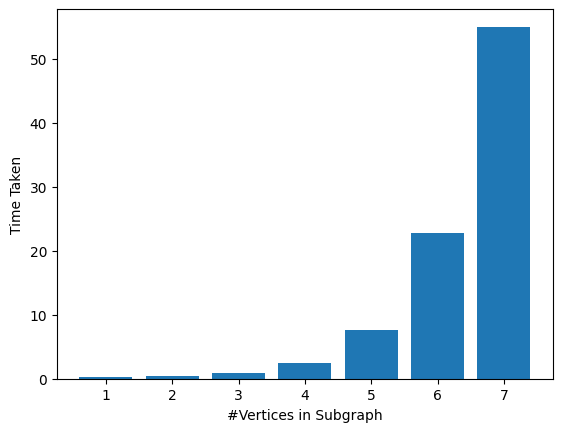

In [84]:
plt.bar(np.arange(1,8), k_time_list)
plt.xlabel("#Vertices in Subgraph")
plt.ylabel("Time Taken")

In [92]:
class0_data_list = [i for i in mutag_data_list if i.x["y"][0] == 0]
class1_data_list = [i for i in mutag_data_list if i.x["y"][0] == 1]

class0_nx_graph_list = get_nx_graph(class0_data_list)
class1_nx_graph_list = get_nx_graph(class1_data_list)

In [95]:
k = 4
class0_sim = calc_graphkern_sim(class0_nx_graph_list, k)
class1_sim = calc_graphkern_sim(class1_nx_graph_list, k)

In [105]:
# With k = 4
print("Class 0 Mean subgraph similarity is {} with Std.: {}".format(
                                                    np.round(np.mean(class0_sim.flatten()), 3), 
                                                    np.round(np.std(class0_sim.flatten()), 3)))

print("Class 1 Mean subgraph similarity is {} with Std.: {}".format(
                                                    np.round(np.mean(class1_sim.flatten()), 3), 
                                                    np.round(np.std(class1_sim.flatten()), 3)))

Class 0 Mean subgraph similarity is 0.573 with Std.: 0.361
Class 1 Mean subgraph similarity is 0.769 with Std.: 0.238


In [106]:
k = 5
class0_sim = calc_graphkern_sim(class0_nx_graph_list, k)
class1_sim = calc_graphkern_sim(class1_nx_graph_list, k)

In [107]:
# With k = 5
print("Class 0 Mean subgraph similarity is {} with Std.: {}".format(
                                                    np.round(np.mean(class0_sim.flatten()), 3), 
                                                    np.round(np.std(class0_sim.flatten()), 3)))

print("Class 1 Mean subgraph similarity is {} with Std.: {}".format(
                                                    np.round(np.mean(class1_sim.flatten()), 3), 
                                                    np.round(np.std(class1_sim.flatten()), 3)))

Class 0 Mean subgraph similarity is 0.519 with Std.: 0.343
Class 1 Mean subgraph similarity is 0.704 with Std.: 0.246
